In [17]:
# imports
import torch
import torch.nn as nn
import numpy as np

# importing iris dataset
import seaborn as sns
iris_dataset = sns.load_dataset('iris')

# direct access to torch.nn functions (without using classes)
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib_inline
from IPython import display
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Transforming Data

In [18]:
# converting from pandas dataframe to pytorch tensor
torched_iris_dataset= torch.tensor(iris_dataset[iris_dataset.columns[0:4]].values).float() # only use first 4 columns, because last column is outcome variable or datatype.

# numeric transformation - transforming species name to a number (0-2)
labels = torch.zeros(len(torched_iris_dataset), dtype=torch.long) # species 'setosa' will remain 0.
labels[iris_dataset.species=='versicolor'] = 1
labels[iris_dataset.species=='virginica'] = 2

---
# Creating Class for ANN model

In [19]:
class ANN_iris(nn.Module):
    def __init__(self, number_units, number_layers):
        super().__init__()

        # creating dictionary to store the layers
        self.layers = nn.ModuleDict()
        self.number_layers = (number_layers) # total number of layers starting at 0

        # input layer
        self.layers['input'] = nn.Linear(4, number_units) # 4 x n, 4 is number of features and n is the number of units

        # hidden layers
        for i in range(number_layers):
            self.layers[f'hidden_{i}'] = nn.Linear(number_units, number_units) # n X n, where n is number of units

        # output layer
        self.layers['output'] = nn.Linear(number_units, 3) # n x 3, where n is number of units and 3 is the number of classes

    def forward(self, x):
        # input layer
        x = self.layers['input'](x)

        # hidden layers
        for i in range(self.number_layers):
            hidden_layer = F.relu(self.layers[f'hidden_{i}'](x))

        # output layer
        output_layer = self.layers['output'](hidden_layer)

        return output_layer

In [20]:
# create model object
num_units_per_layer = 12
n_layers = 4
net = ANN_iris(num_units_per_layer,n_layers)
net

ANN_iris(
  (layers): ModuleDict(
    (input): Linear(in_features=4, out_features=12, bias=True)
    (hidden_0): Linear(in_features=12, out_features=12, bias=True)
    (hidden_1): Linear(in_features=12, out_features=12, bias=True)
    (hidden_2): Linear(in_features=12, out_features=12, bias=True)
    (hidden_3): Linear(in_features=12, out_features=12, bias=True)
    (output): Linear(in_features=12, out_features=3, bias=True)
  )
)

---
## Testing the Model
- This is done **before** adding entire dataset to ensure the model architecture is correctly set up.

In [21]:
# create 10 samples of fake data with 4 features
fake_data = torch.randn(10,4)

# pass the fake data to the model
y = net(fake_data)

# double check the shape of the output
print(f"output shape ={y.shape}")
print(f"network output = {y}")


output shape =torch.Size([10, 3])
network output = tensor([[-0.2415, -0.1566,  0.4233],
        [ 0.1097,  0.0480,  0.0195],
        [-0.0607, -0.0327,  0.0959],
        [ 0.0259,  0.0227, -0.0110],
        [-0.0602, -0.0202,  0.1006],
        [-0.0449, -0.0128,  0.0958],
        [-0.1488,  0.0065,  0.1403],
        [-0.1344, -0.1356,  0.1864],
        [-0.1118,  0.0108,  0.0632],
        [ 0.2234,  0.0529,  0.0098]], grad_fn=<AddmmBackward0>)


---
## Training the Model

In [22]:
def ANN_classification_training(model, loss_function, m_optimizer, input_data, input_labels, epochs = 1000):
    
    # parameters
    losses = torch.zeros(epochs)
    per_epoch_accuracy = []
    
    # training
    for epoch_IDX in range(epochs):
        # forward pass
        y_hat = model(input_data)
        
        # calculating loss
        loss = loss_function(y_hat, input_labels)
        losses[epoch_IDX] = loss
        # backprop
        m_optimizer.zero_grad()
        loss.backward()
        m_optimizer.step()

        # calculating accuracy at each epoch
        matches = torch.argmax(y_hat, axis=1) == input_labels # converting to booleans (T / F)
        matches_num = matches.float()                         # convert bools to ints (0 / 1)
        accuracy_percent = 100*torch.mean(matches_num)        # average of correct matches
        per_epoch_accuracy.append(accuracy_percent)

    # final forward pass
    final_predictions = model(input_data)

    # overall accuracy
    predicted_lables = torch.argmax(final_predictions, axis=1)
    total_accuracy = 100*torch.mean((predicted_lables==input_labels).float())

    # total number of trainable parameters in the model 
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    return final_predictions, losses, per_epoch_accuracy, total_accuracy, y_hat, num_params

### Quick Test for the Training function

In [23]:
# checking that training function works properly and gives expected output
num_epochs = 1000
net_predictions, net_losses, net_accuracy, net_total_accuracy, net_y_hat, net_num_params = ANN_classification_training(net, nn.CrossEntropyLoss(), torch.optim.SGD(net.parameters(), lr=0.01), torched_iris_dataset, labels, num_epochs)
print(net_total_accuracy, net_num_params)

tensor(98.) 723


---
# Parametric Experiment 
- Parametric study of varying both width / breadth and depth of the model's layers.

In [27]:
# model parameters
number_layers = range(1,6) # range of layers from 1 to 5
number_units = np.arange(4,101,3) # range of units per layer from 4 to 100 in steps of 3

# initialize output matrices
accuracy_matrix = np.zeros((len(number_units), len(number_layers)))
total_params_matrix = np.zeros((len(number_units), len(number_layers)))

# experiment parameters
num_epochs = 1000

# loop through every unit
for unit_idx in range(len(number_units)):
    # loop through every layer
    for layer_idx in range(len(number_layers)):

        # create model
        iris_model = ANN_iris(number_units[unit_idx], number_layers[layer_idx])

        # train model
        final_predictions, losses, per_epoch_accuracy, total_accuracy, y_hat, num_params = ANN_classification_training(iris_model, nn.CrossEntropyLoss(), torch.optim.SGD(iris_model.parameters(), lr=0.01), torched_iris_dataset, labels, num_epochs)

        # store accuracy
        accuracy_matrix[unit_idx, layer_idx] = total_accuracy

        # store accuracy and number of parameters
        total_params_matrix[unit_idx, layer_idx] = num_params

## Plotting the results

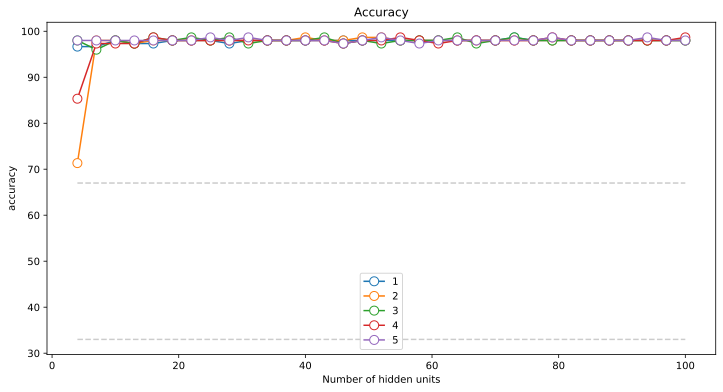

In [28]:
# Plotting accuracy for each experiment iteration.
fig,ax = plt.subplots(1,figsize=(12,6))

ax.plot(number_units,accuracy_matrix,'o-',markerfacecolor='w',markersize=9)
ax.plot(number_units[[0,-1]],[33,33],'--',color=[.8,.8,.8])
ax.plot(number_units[[0,-1]],[67,67],'--',color=[.8,.8,.8])
ax.legend(number_layers)
ax.set_ylabel('accuracy')
ax.set_xlabel('Number of hidden units')
ax.set_title('Accuracy')
plt.show()



### Interpreting the results.
- The model with one hidden layers appears to learn quicker and more consistently.
- This indicates that a deeper model with more layers is not necessarily going to be better. It depends on the complexity of the problem.
---

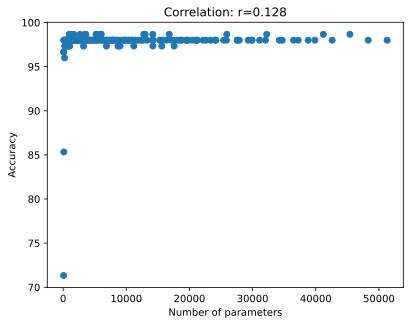

In [29]:
# Plotting number of parameters for each experiment iteration.

# Flattening these matrices into vectors for plotting
x = total_params_matrix.flatten()
y = accuracy_matrix.flatten()

# Correlation coefficient between parameters and accuracy
r = np.corrcoef(x,y)[0,1]

# Scatter plot
plt.plot(x,y,'o')
plt.xlabel('Number of parameters')
plt.ylabel('Accuracy')
plt.title('Correlation: r=' + str(np.round(r,3)))
plt.show()

### Examing the Results.
- There is no meaningful correlation between the number of trainable parameters and the model accuracy.